In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [5]:
# if structure == 'VCA':
#     roi_xmin = 968 * 8
#     roi_ymin = 827 * 8
#     roi_w = 435 * 8
#     roi_h = 357 * 8
#     filenames = ['MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111'] # example for VCA
# elif structure == '7N':
#     roi_xmin = 850 * 8
#     roi_ymin = 973 * 8
#     roi_w = 562 * 8
#     roi_h = 639 * 8
#     filenames = ['MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155'] # example for 7N
# elif structure == 'DC':
#     roi_xmin = 912 * 8
#     roi_ymin = 597 * 8
#     roi_w = 694 * 8
#     roi_h = 634 * 8
# #     filenames = ['MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115']
#     filenames = ['MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118']
# elif structure == '10N':
#     roi_xmin = 1376 * 8
#     roi_ymin = 817 * 8
#     roi_w = 474 * 8
#     roi_h = 392 * 8
#     filenames = ['MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226']
#     filenames = ['MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227']
#     stack = 'MD661'
#     section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
#     filenames = ['MD658-F49-2017.04.05-03.36.45_MD658_2_0146']
#     roi_xmin = 1498 * 8
#     roi_ymin = 905 * 8
#     roi_w = 360 * 8
#     roi_h = 222 * 8
#     stack = 'MD658'
#     section_to_filename = metadata_cache['sections_to_filenames'][stack]

In [5]:
# stack = 'MD661'
stack = 'ChatCryoJane201710'

In [6]:
windowing_id = 5

windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]
half_size = patch_size/2

grid_spec = (patch_size, spacing, w, h)

sample_locations_ = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [59]:
contours_df = DataManager.load_annotation_v4(stack=stack, by_human=True, suffix='contours', timestamp='latest')
contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
# contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'downsample', 'creator'])

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/ChatCryoJane201710" "/home/yuncong/CSHL_labelings_v3/ChatCryoJane201710" --exclude "*" --include "*contours*"
latest timestamp:  11092017163602


In [60]:
contours_df = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack, out_downsample=1)

download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=2), is_dir=True)
contours_grouped = contours_df.groupby('section')

In [61]:
# Get bounding boxes for every structure on every section.

margin_um = 500

local_region_bboxes_allStructures_allSections = {structure: {} for structure in all_known_structures_sided}
for structure in all_known_structures_sided:
    name, side = parse_label(structure)[:2]
    if side is None:
        side = 'S'
    margin_pixel = margin_um / XY_PIXEL_DISTANCE_LOSSLESS
    q = contours_df[(contours_df['name'] == name) & (contours_df['side'] == side)]
    for cnt_id, cnt in q.iterrows():
        vs = cnt['vertices']
        xmin, ymin = vs.min(axis=0) 
        xmax, ymax = vs.max(axis=0)
        local_region_bboxes_allStructures_allSections[structure][cnt['section']] = (max(0, int(np.floor(xmin-margin_pixel))),
                                            min(w-1, int(np.ceil(xmax+margin_pixel))),
                                            max(0, int(np.floor(ymin-margin_pixel))),
                                            min(h-1, int(np.ceil(ymax+margin_pixel))))

In [62]:
local_region_bboxes_allStructures_allSections

{'10N_L': {},
 '10N_R': {},
 '12N': {},
 '3N_L': {},
 '3N_R': {},
 '4N_L': {},
 '4N_R': {},
 '5N_L': {},
 '5N_R': {},
 '6N_L': {},
 '6N_R': {},
 '7N_L': {90: (12814, 16009, 14871, 17482),
  91: (12721, 16047, 14833, 17511),
  92: (12545, 16143, 14777, 17583),
  93: (12417, 16239, 14729, 17639),
  94: (12233, 16343, 14673, 17703),
  95: (12060, 16452, 14621, 17782),
  96: (12065, 16455, 14577, 17839),
  97: (12057, 16495, 14545, 17895),
  98: (12033, 16511, 14513, 17959),
  99: (12009, 16535, 14473, 18023),
  100: (11993, 16575, 14433, 18071),
  101: (11953, 16622, 14407, 18179),
  102: (11945, 16615, 14385, 18143),
  103: (11929, 16631, 14361, 18143),
  104: (11913, 16639, 14353, 18183),
  105: (11878, 16696, 14318, 18266),
  106: (11881, 16607, 14305, 18231),
  107: (11865, 16543, 14289, 18295),
  108: (11850, 16498, 14241, 18404),
  109: (11841, 16391, 14329, 18263),
  110: (11795, 16316, 14334, 18128)},
 '7N_R': {},
 '7n_L': {},
 '7n_R': {},
 'AP': {},
 'Amb_L': {},
 'Amb_R': {},
 '

# See classifier response

In [201]:
# Variants in testing, then use the maximum
# test_variants = range(0, 8)
test_variants = range(0, 1)

# intensity_ranges = ['min', 'median', 'max', 'sec_specific_median']
intensity_ranges = [(65535,0), (50000,0), (40000,0), (30000,0), (20000,0), (10000,0)]

In [202]:
structures = ['SNR']

In [203]:
sec = 103

roi_xmin, roi_xmax, roi_ymin, roi_ymax = local_region_bboxes_allStructures_allSections['SNR_L'][sec]
roi_w = roi_xmax + 1 - roi_xmin
roi_h = roi_ymax + 1 - roi_ymin
filenames = [metadata_cache['sections_to_filenames'][stack][sec]]

In [204]:
sparse_grids_allSchemes_allFns_allStructs = {}
features_allSchemes_allFns_allVariants = defaultdict(lambda: defaultdict(dict))

locate patches: 0.08 seconds
8096 samples.


convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S1_prep2_lossless_Ntb.tif -crop 7235x6987+3135+7847 /tmp/tmp.tif


Read: 33.70 seconds
Adjust contrast: 1.03 seconds


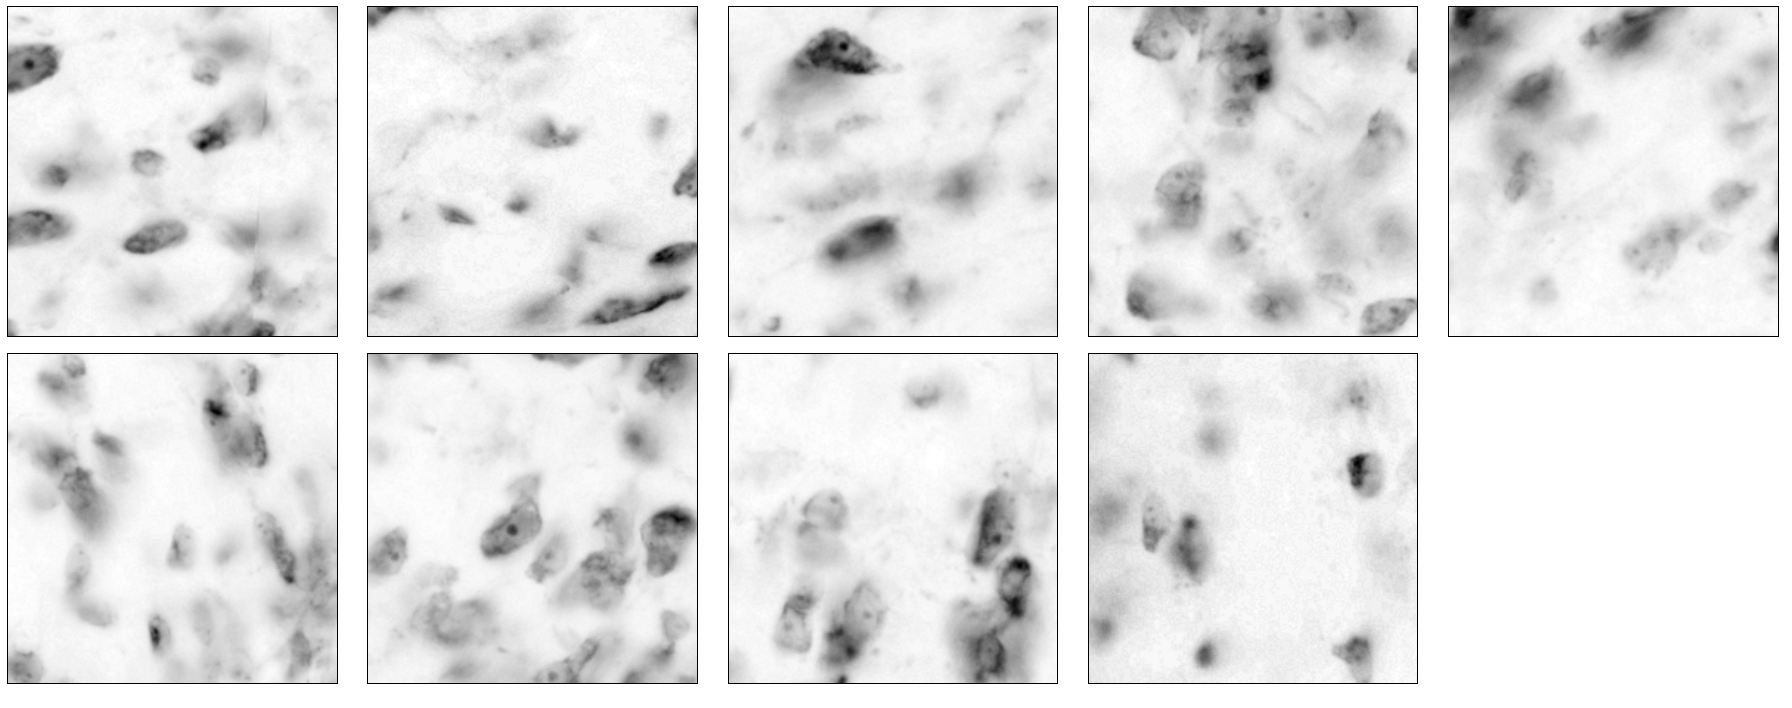

Extract patches: 1.60 seconds
Variants: 0.01 seconds


(8096, 1, 224, 224)


Feature extraction: 11.94 seconds
Adjust contrast: 1.29 seconds


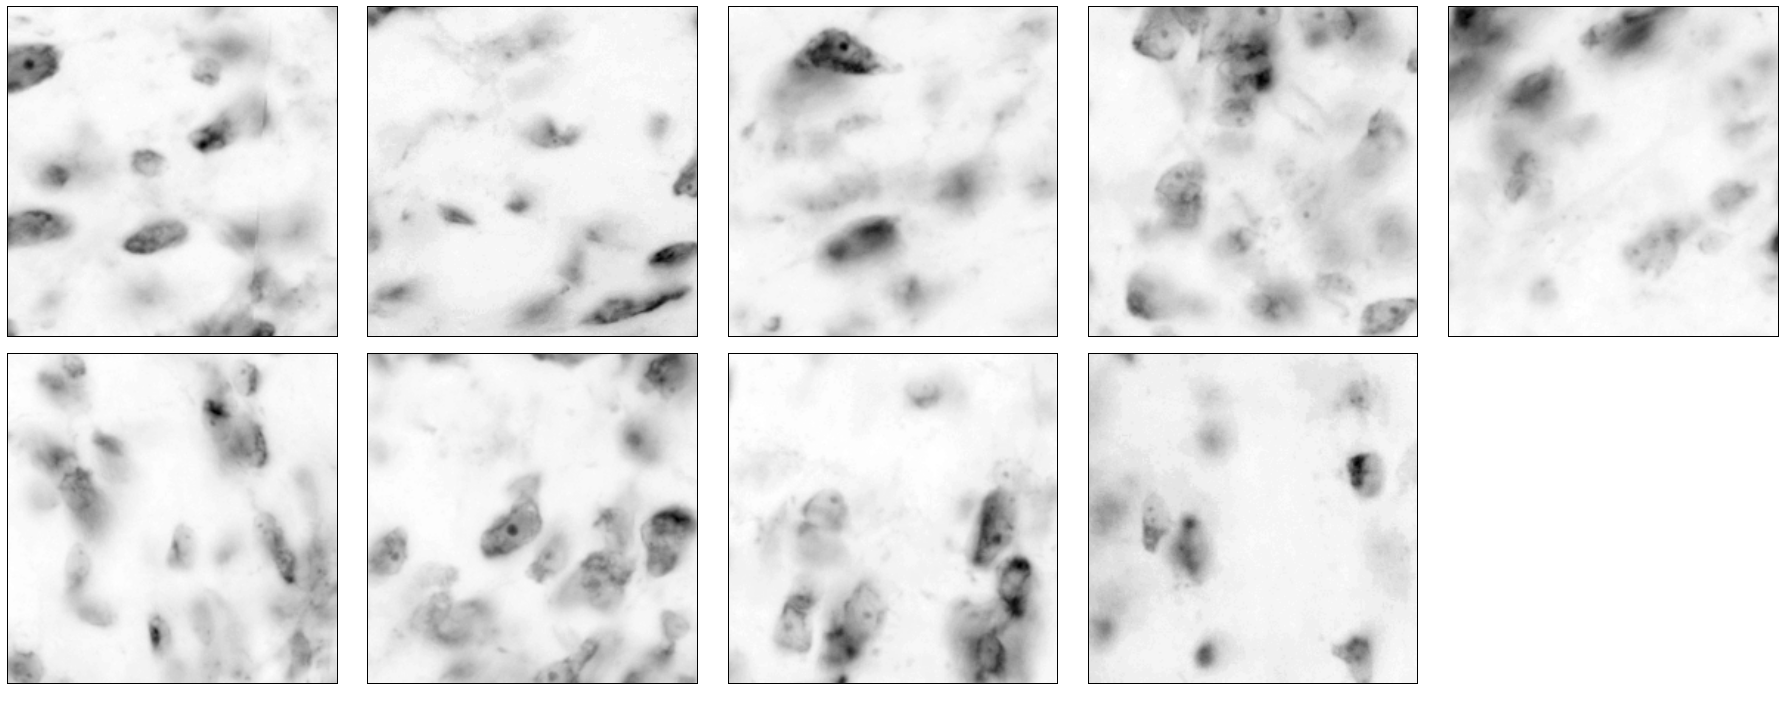

Extract patches: 2.31 seconds
Variants: 0.01 seconds


(8096, 1, 224, 224)


Feature extraction: 11.75 seconds
Adjust contrast: 1.30 seconds


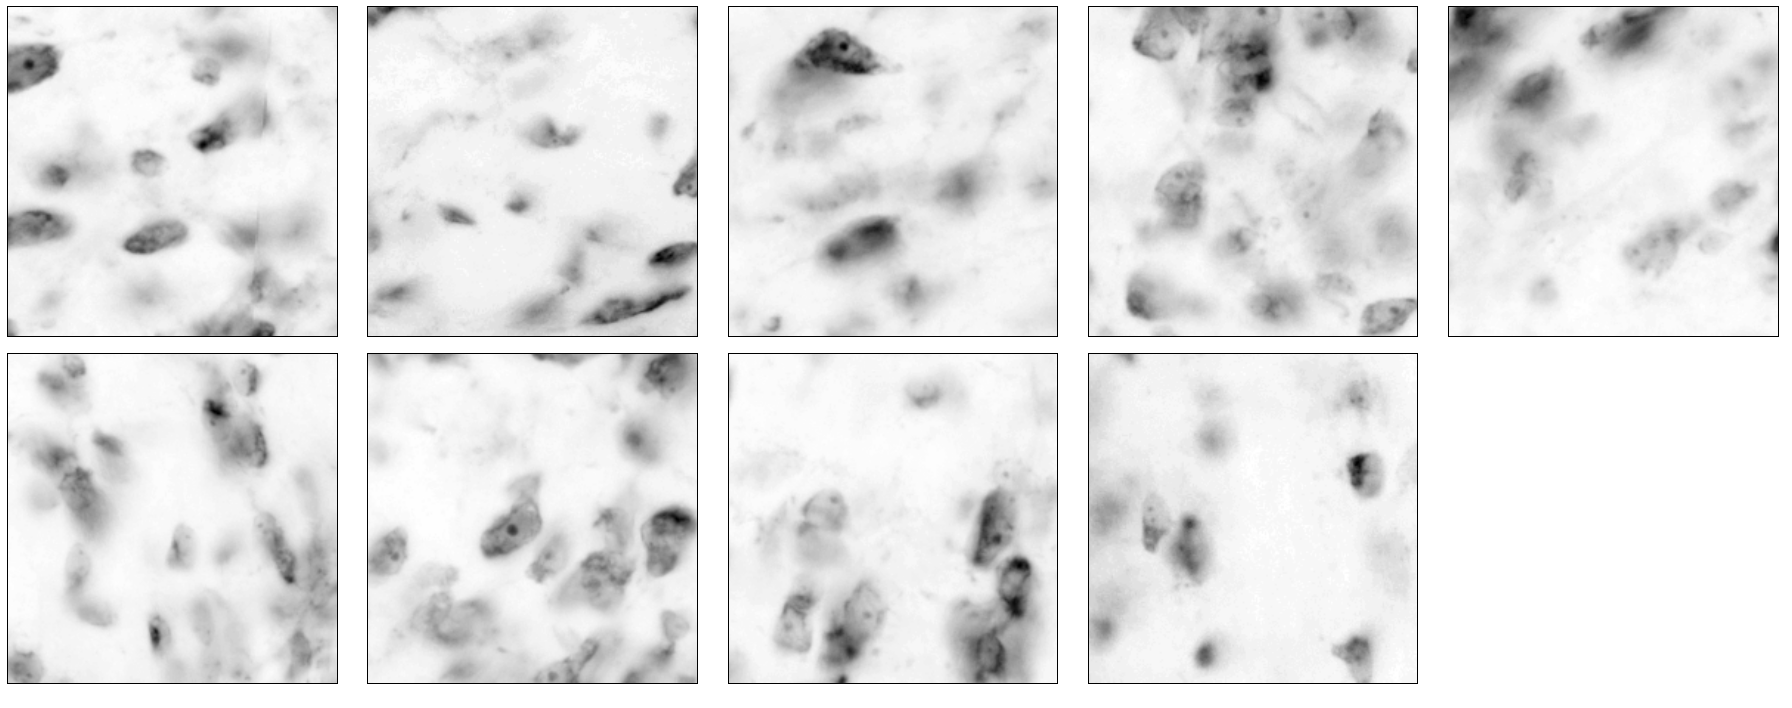

Extract patches: 2.38 seconds
Variants: 0.02 seconds


(8096, 1, 224, 224)


Feature extraction: 11.83 seconds
Adjust contrast: 1.05 seconds


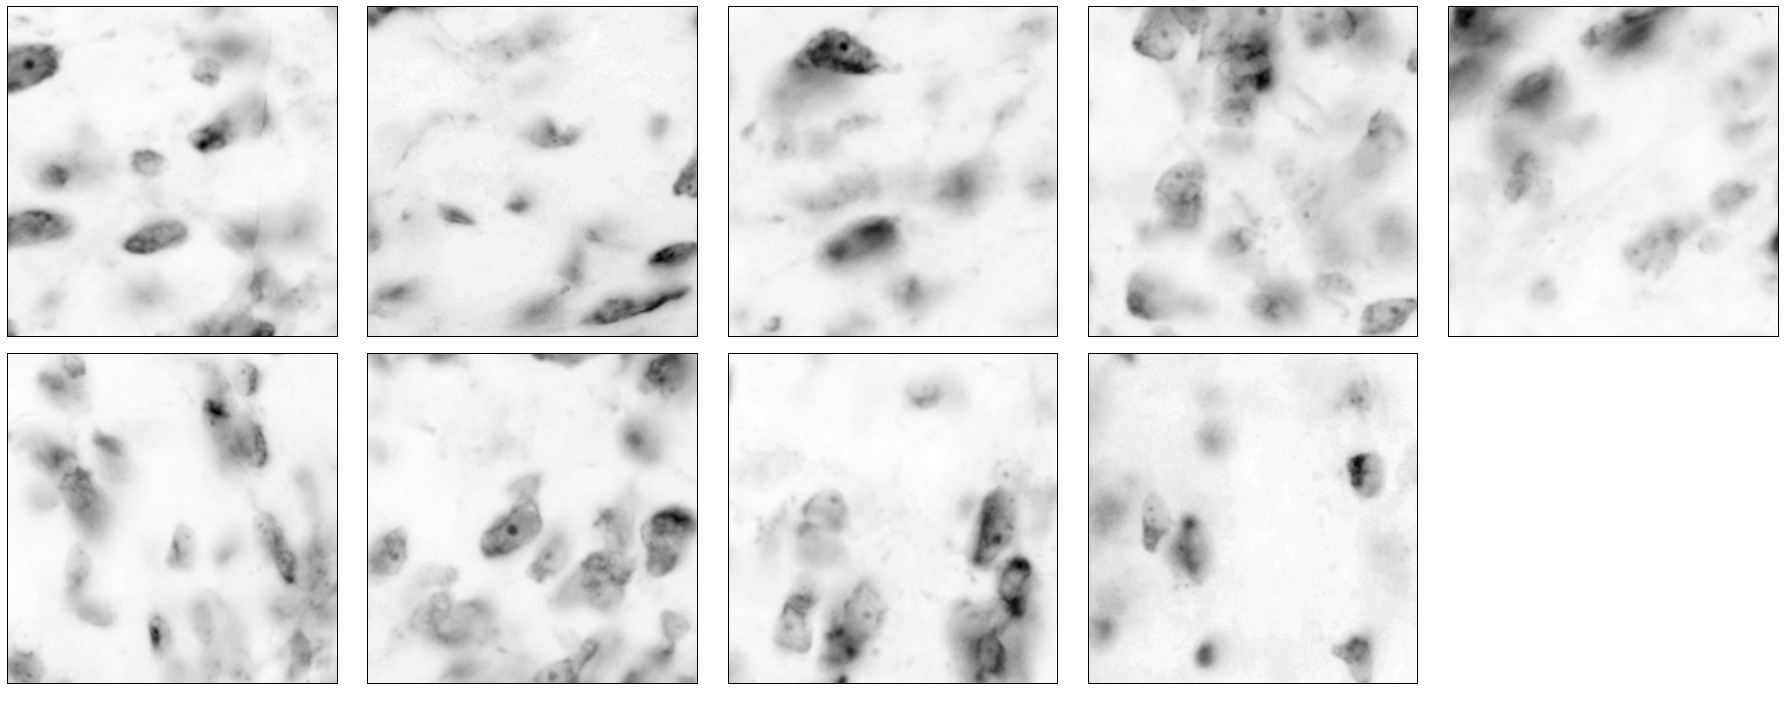

Extract patches: 1.40 seconds
Variants: 0.00 seconds


(8096, 1, 224, 224)


Feature extraction: 11.63 seconds
Adjust contrast: 1.02 seconds


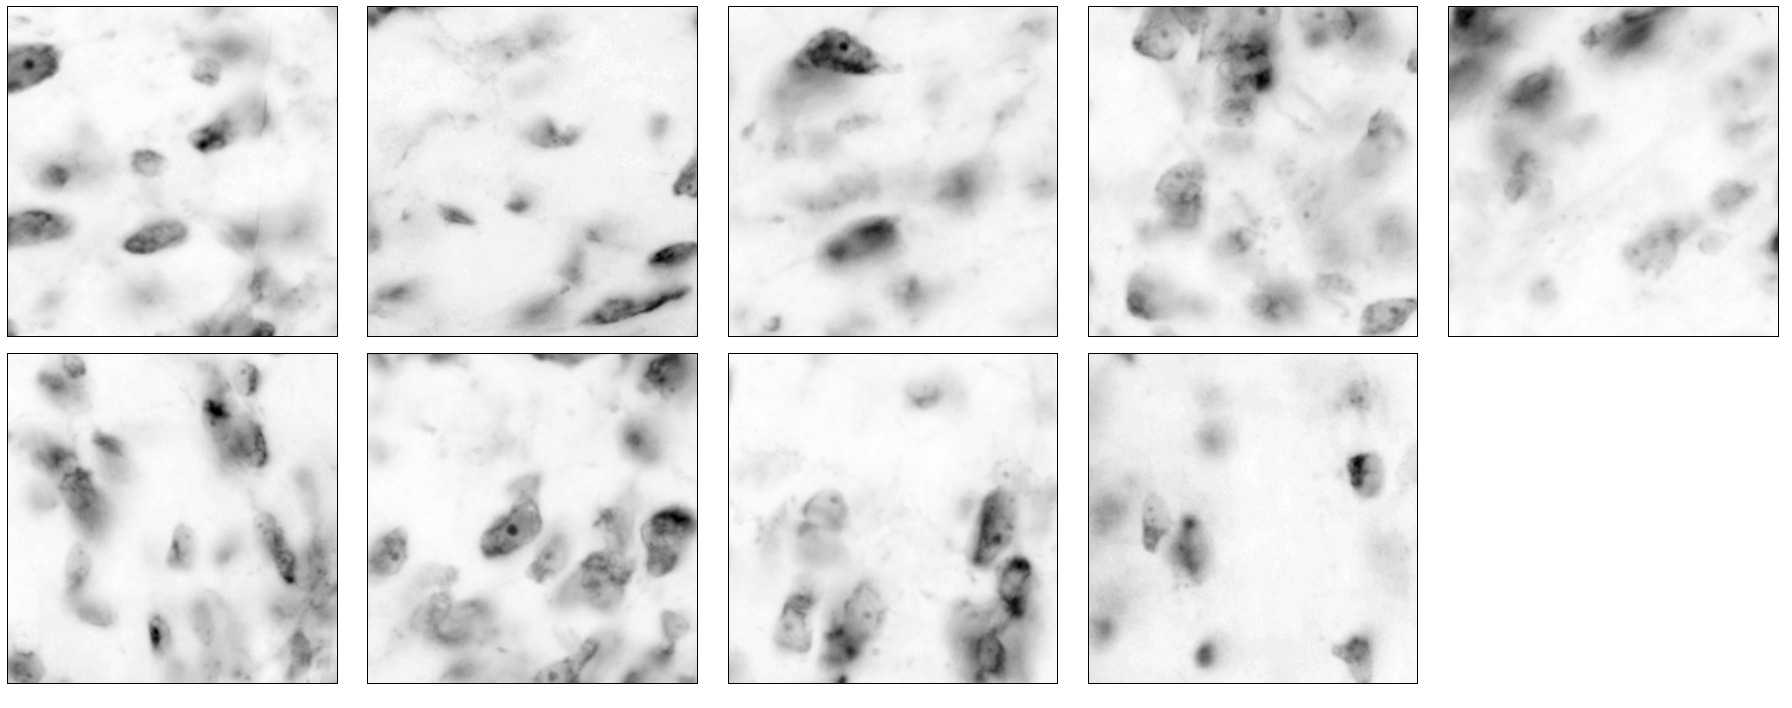

Extract patches: 1.46 seconds
Variants: 0.01 seconds


(8096, 1, 224, 224)


Feature extraction: 11.66 seconds
Adjust contrast: 1.02 seconds


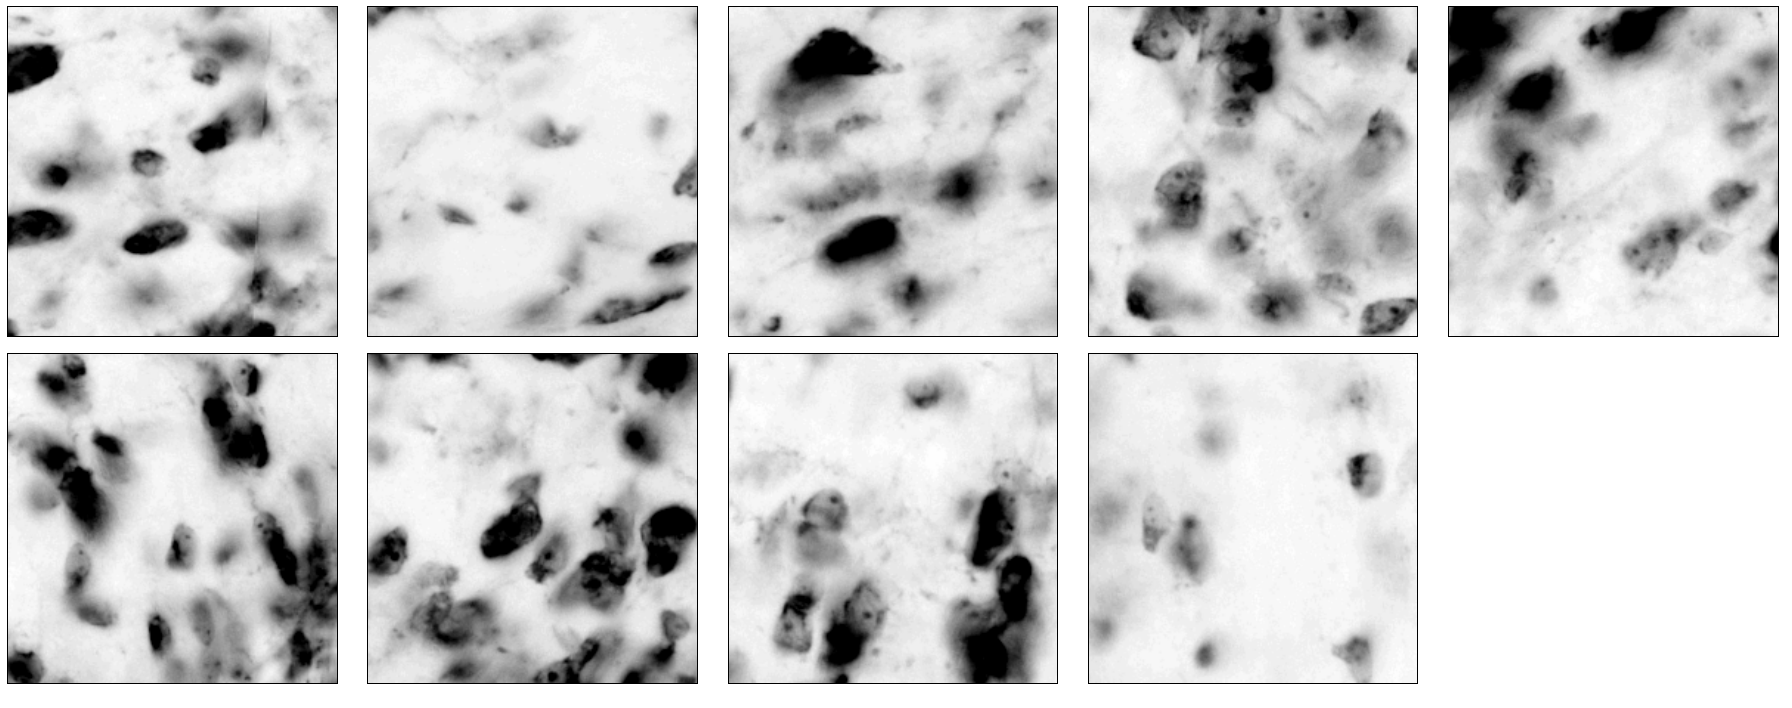

Extract patches: 1.42 seconds
Variants: 0.00 seconds


(8096, 1, 224, 224)


Feature extraction: 12.08 seconds


In [205]:
for fn in filenames:

    ####################

    t = time.time()
    mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, fn=fn)
    indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb, 
                                    bbox_lossless=(roi_xmin,roi_ymin,roi_w,roi_h))
    sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

    sparse_grids_allSchemes_allFns_allStructs[fn] = indices_roi

    n = len(indices_roi)
    sys.stderr.write('%d samples.\n' % n)

    ############################

    sample_locations_roi = sample_locations_[indices_roi]

    ###########################

    t = time.time()
#     img_blue = DataManager.load_image_v2(stack=stack, fn=fn, prep_id=2, resol='lossless')[..., 2]
#     img_blue = DataManager.load_image_v2(stack=stack, fn=fn, prep_id=2, resol='lossless', version='Ntb')

    img_blue_fp = DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=2, resol='lossless', version='Ntb')
    img_blue_local_region = crop_large_image(fp=img_blue_fp, 
                                             bbox=(roi_xmin-666,roi_xmax+666,roi_ymin-666,roi_ymax+666))
    
    sys.stderr.write('Read: %.2f seconds\n' % (time.time() - t))

    for scheme in intensity_ranges:
        t = time.time()
        if scheme in ['min', 'median', 'max', 'sec_spec_median']:
            if scheme == 'min':
                mapping_fp = os.path.join(DATA_DIR, 'min_nissl_intensity_mapping.npy')
            elif scheme == 'median':
                mapping_fp = os.path.join(DATA_DIR, 'median_nissl_intensity_mapping.npy')
            elif scheme == 'max':
                mapping_fp = os.path.join(DATA_DIR, 'max_nissl_intensity_mapping.npy')
            elif scheme == 'sec_spec_median':
                mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath(stack=stack, ntb_fn=fn)                
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized = intensity_mapping_ntb_to_nissl[img_blue_local_region.astype(np.int)].astype(np.uint8)            
        else:
            low, high = scheme
            img_blue_intensity_normalized = rescale_intensity_v2(img_blue_local_region, low, high)
        sys.stderr.write('Adjust contrast: %.2f seconds\n' % (time.time() - t))

#         patches = np.array([img_blue_intensity_normalized[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224

        t = time.time()
        patches = extract_patches_given_locations(img=img_blue_intensity_normalized, 
                                                  locs=sample_locations_roi - (roi_xmin-666, roi_ymin-666), 
                                                  patch_size=224)
        display_images_in_grids(patches[::1000], nc=5, cmap=plt.cm.gray)
        sys.stderr.write('Extract patches: %.2f seconds\n' % (time.time() - t))

#         extra_margin = 200
#         patches_enlarged = extract_patches_given_locations(img=img_blue_intensity_normalized, 
#                                                            locs=sample_locations_roi, 
#                                                            patch_size=224+2*extra_margin)            
        for variant in test_variants:

            t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
            patches_rotated = rotate_all_patches_variant(patches, variant=variant)
            sys.stderr.write('Variants: %.2f seconds\n' % (time.time() - t))

            #############################

            t1 = time.time()
            features = convert_image_patches_to_features(patches_rotated, model=model, 
                                                         mean_img=mean_img, 
                                                         batch_size=batch_size)

            features_allSchemes_allFns_allVariants[scheme][fn][variant] = features
            sys.stderr.write('Feature extraction: %.2f seconds\n' % (time.time() - t1))

            #################################

features_allSchemes_allFns_allVariants.default_factory = None

In [184]:
classifier_settings

model  margin_um       train_set_id  \
classifier_id                                                            
30                                    lr        500              20/21   
31                                    lr        500              21/22   
32                                    lr        500              20/22   
33                                   gb1        500              20/21   
34                                   gb1        500              21/22   
35                                   gb1        500              20/22   
36                                   gb1        500              23/24   
37                                    lr        500              23/24   
38                                    lr        500        23/24/27/28   
39                                    lr        200        30/31/27/28   
40                                    lr       1000        33/34/27/28   
41                                    lr        500        36/37/27/28   
42                                    lr        500        39/40/27/28   
50                                    lr        500  27/28/29/60/61/62   
70             inception-bn-blue-softmax        500              60/61   
71             inception-bn-blue-softmax        500           60/61/62   
72                                    lr        500           66/67/68   
73                                    lr        500           66/67/68   
74                                    lr        500           72/73/74   
75                                    lr        500           72/73/74   
76                                    lr        500           75/76/77   
77                                    lr        500           66/67/68   
78                                  xgb2        500           66/67/68   
79                               lin_svc        500           66/67/68   
80                                    lr        500              23/24   
81                                    lr        500              23/24   
82                                    lr        500              23/24   
83                                    lr        500              23/24   
84                                    lr        500              23/24   
95                                   gb2        500                 93   
96                                   gb2        500                 95   
97                                   gb2        500                 97   
98                                   gb2        500                 99   
99                                    lr        500                 99   
110                                   lr        500           66/67/68   
111                                   lr        500           66/67/68   
112                                   lr        500              66/67   
113                                   lr        500              66/67   
114                                   lr        500              78/79   
115                                 xgb2        500              66/67   
116                              lin_svc        500              66/67   
120                                   lr        500           75/76/77   
130                                   lr        500        110/111/112   
131                                   lr        500            113/114   
132                                   lr        500            113/115   
133                                   lr        500            114/115   
134                                   lr        500        113/114/115   

                             neg_composition  sample_weighting  \
classifier_id                                                    
30                      neg_has_all_surround               NaN   
31                      neg_has_all_surround               NaN   
32                      neg_has_all_surround               NaN   
33                      neg_has_all_surround               NaN   
34          

In [185]:
classifier_settings.loc[72]['comment'], classifier_settings.loc[73]['comment']

('using mirror variations of patches to train; use both surround and far as negative',
 'using mirror variations for training; use only surround as negative')

In [186]:
from sklearn.externals import joblib

available_classifiers = {}

# for classifier_id in [72, 73, 74, 75, 76]:
for classifier_id in [72, 73]:
# for classifier_id in [73]:

    clf_allClasses = {}
    for structure in all_known_structures:
        clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
        download_from_s3(clf_fp, local_root=DATA_ROOTDIR)
        if os.path.exists(clf_fp):
            clf_allClasses[structure] = joblib.load(clf_fp)
        else:
            sys.stderr.write('Classifier for %s is not found.\n' % structure)

    classifier_properties = classifier_settings.loc[classifier_id]
    svm_id = int(classifier_properties['svm_id'])
    
    available_classifiers[svm_id] = clf_allClasses

In [187]:
# "condition" involves the choice of classifier and whether in testing multiple rotations are used.

# test_with_rot = testing considers the maximum among the scores achieved by eight rotations of the test patch.
# test_no_rot = testing considers the test patch as it is.

conditions = [(72, 'test_no_rot'),
              (73, 'test_no_rot')]
#             (74, 'test_with_rot'),
#             (75, 'test_with_rot'),
#              (76, 'test_with_rot')]

In [188]:
sparse_scores_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for condition in conditions:
    
    if condition[1] == 'test_no_rot':
        test_variants = range(1)
    elif condition[1] == 'test_with_rot':
        test_variants = range(8)
    
    svm_id = condition[0]
        
    for fn in filenames:
        for low, high in intensity_ranges:
#         for low, high in [(-200,0)]:

            probs_allClasses_allVariations = []

            for variant in test_variants:
                
                def clf_predict(stack, fn):
                    clf_allClasses_ = available_classifiers[svm_id]
                    probs_allClasses = {}
                    for s in structures:
                        clf = clf_allClasses_[s]
                        features = features_allSchemes_allFns_allVariants[(low, high)][fn][variant]
                        probs = clf.predict_proba(features)[:, clf.classes_.tolist().index(1.)]
                        probs_allClasses[s] = probs
                    return probs_allClasses

                t = time.time()

                probs_allClasses = clf_predict(stack=stack, fn=fn)
                probs_allClasses_allVariations.append(probs_allClasses)

                #         probs_allFns_allClasses[fn] = clf_predict(stack=stack, fn=fn)

                #         pool = Pool(NUM_CORES/2)
                #         probs_allFns_allClasses = dict(zip(filenames, pool.map(lambda fn: clf_predict(stack=stack, fn=fn), filenames)))
                #         pool.close()
                #         pool.join()
                sys.stderr.write('Classifier predict: %.2f s\n' % (time.time()-t))

            for s in structures:
                pvs = [probs_allClasses_allVariations[v][s] for v in test_variants]
                sparse_scores_allSchemes_allFns_allStructs_allConditions[(low,high)][fn][s][condition] = np.max(pvs, axis=0)    

sparse_scores_allSchemes_allFns_allStructs_allConditions.default_factory = None

Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s
Classifier predict: 0.01 s


In [189]:
# X = defaultdict(dict)
# for intens, x in sparse_scores_allSchemes_allFns_allStructs_allConditions.iteritems():
#     for cond, scores in x[fn]['7N'].iteritems():
#         X[cond][intens] = scores
        
# best_scheme = {}
# best_sparse_scores = {}
# for cond, y in X.iteritems():
#     ii, ss = zip(*y.items())
#     ss = np.array(ss)
#     ii = list(ii)
#     ssargmax = np.argmax(ss, axis=0)
#     best_scheme[cond] = [ii[i] for i in ssargmax]
#     best_sparse_scores[cond] = np.array([ss[ii.index(i), p] for p, i in enumerate(best_scheme[cond])])

In [190]:
# from collections import Counter
# schemes, counts = zip(*sorted(Counter(sorted(best_scheme[(72, 'test_no_rot')])).items()))

# plt.figure(figsize=(20,5));
# plt.bar(range(len(schemes)), counts);
# plt.xticks(range(len(schemes)), schemes);
# plt.title('Distribution of the highest scoring scheme among all patches');
# plt.ylabel('Number of patches');
# plt.xlabel('Intensity scheme');

# See the score maps

In [191]:
# conditions = [(72, 'test_with_rot'),
#               (73, 'test_with_rot')]
conditions = [(72, 'test_no_rot'),
              (73, 'test_no_rot')]

In [192]:
scoremap_viz_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [193]:
downscale = 32
img_blue_intensity_normalized = {}

# img_blue_local_region = img_blue[roi_ymin:(roi_ymin+roi_h), roi_xmin:(roi_xmin+roi_w)]
# img_blue_local_region2 = crop_large_image(fp=img_blue_fp, bbox=(roi_xmin,roi_xmax,roi_ymin,roi_ymax))
img_blue_local_region2 = img_blue_local_region

for fn in filenames:
    
    for intens in intensity_ranges:
        low, high = intens
        if low == -100:
            mapping_fp = os.path.join(DATA_DIR, 'min_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region2.astype(np.int)].astype(np.uint8)
        elif low == -200:
            mapping_fp = os.path.join(DATA_DIR, 'median_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region2.astype(np.int)].astype(np.uint8)
        elif low == -300:
            mapping_fp = os.path.join(DATA_DIR, 'max_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region2.astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized[intens] = rescale_intensity_v2(img_blue_local_region2, low, high)
            

    for structure in structures:
        for intens in intensity_ranges:
            for cond in conditions:

                def resample_scoremap(fn, s):
                    """
                    Args:
                        s: structure
                        
                    Returns:
                        : scoremap (downscale=32)
                    """
                    
                    downscaled_grid_y = np.arange(0, h, downscale)
                    downscaled_grid_x = np.arange(0, w, downscale)
                    downscaled_ny = len(downscaled_grid_y)
                    downscaled_nx = len(downscaled_grid_x)

                    sparse_scores = sparse_scores_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] 

                    f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                    a = (sample_locations_roi - half_size)/spacing
                    f_grid[a[:,1], a[:,0]] = sparse_scores

                    yinterps = (downscaled_grid_y - half_size)/float(spacing)
                    xinterps = (downscaled_grid_x - half_size)/float(spacing)

                    points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                    coord = np.c_[points_y.flat, points_x.flat]
                    f_interp = map_coordinates(f_grid, coord.T, order=1)
                    f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                    scoremap = f_interp_2d.astype(np.float16)
                        
                    return scoremap

#                 t = time.time()
                scoremap = resample_scoremap(fn, structure)
                #         pool = Pool(NUM_CORES/2)
                #         # pool = Pool(1)
                #         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
                #         pool.close()
                #         pool.join()
#                 sys.stderr.write('Resample scoremap: %.2f seconds\n' % (time.time() - t)) 

                #########################
    
                def save_scoremap(structure):
                    scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[intens], 
                                                       in_downscale=1, stack=stack, fn=fn, structure=structure,
                                                       scoremap=scoremap[(roi_ymin-666)/32:(roi_ymin+666+roi_h)/32,
                                                                           (roi_xmin-666)/32:(roi_xmin+666+roi_w)/32],
                                                      in_scoremap_downscale=32,
                                                      out_downscale=8, label_text=str(structure), 
                                                      cmap_name= 'jet')
                #         pool = Pool(NUM_CORES)
                #         structures = scoremaps_allClasses.keys()
                #         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
                #         pool.close()
                #         pool.join()
                    return scoremap_viz

                for s in structures:
                    scoremap_viz_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] = save_scoremap(s)

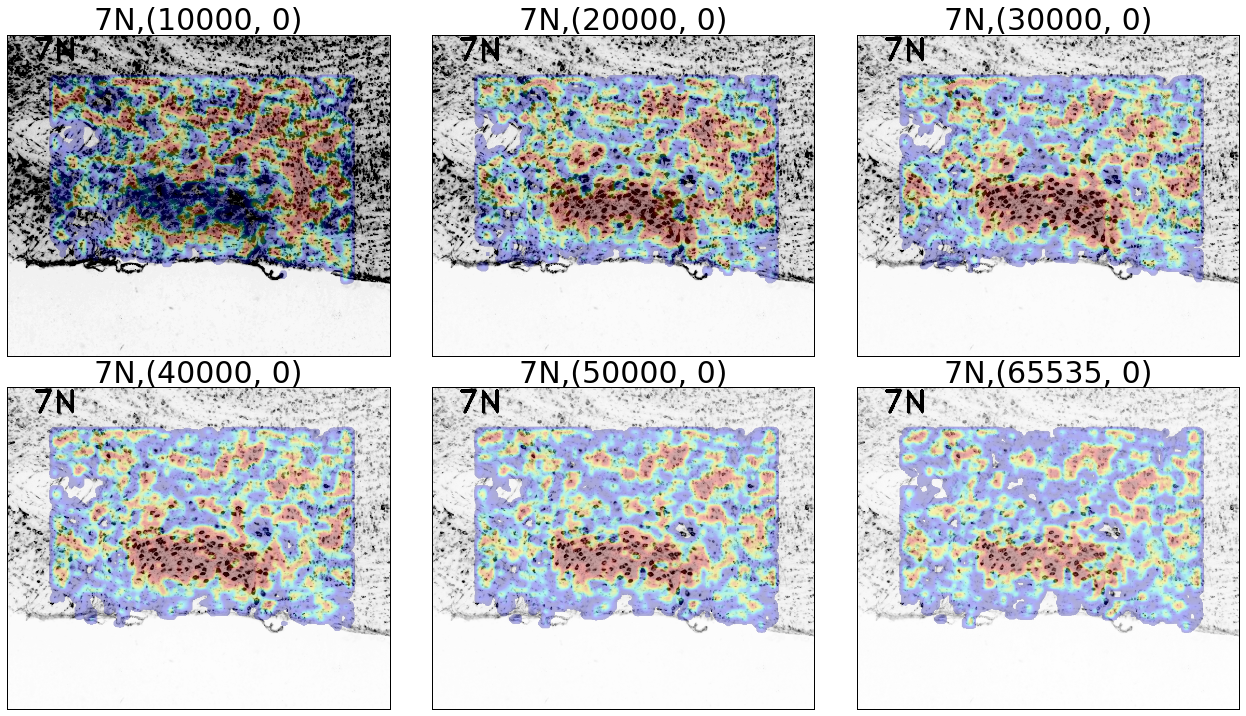

In [194]:
title_viz_tuples = [("%s,%s" % (structures[0],str(scheme)), vizs[structures[0]][(73, 'test_no_rot')])
 for scheme, x in sorted(scoremap_viz_allSchemes_allFns_allStructs_allConditions.items())
 for fn, vizs in x.iteritems()]

titles, vizs = zip(*title_viz_tuples)

display_images_in_grids(vizs=vizs, titles=titles, nc=3)

In [ ]:
grid_index_class_lookup = DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=windowing_id, by_human=True)

In [65]:
def identify_positive_negative_grids(stack, sec, structure, grid_indices, neg_composition_rule):
    """
    Args:
        grid_indices (list of int): grid indices to query
        neg_composition_rule (str): e.g. surround200
    
    Returns:
        (list of boolean, list of boolean): is_pos, is_neg
    """
    
    global grid_index_class_lookup
    d = grid_index_class_lookup.loc[sec].dropna()
    labels_found = list(d.index)

    pos_classes = [structure]
    print 'pos_classes', pos_classes

    if neg_composition_rule.startswith('surround'):
        if neg_composition_rule == 'surround200':
            margin_um = 200
        elif neg_composition_rule == 'surround500':
            margin_um = 500
        elif neg_composition_rule == 'surround1000':
            margin_um = 1000
        else:
            margin_um = None
        neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in all_known_structures]
    elif neg_composition_rule == 'negative':
        neg_classes = [structure + '_negative']
    else:
        raise

    neg_classes = list(set(neg_classes) & set(labels_found))
    print 'neg_classes', neg_classes

    #####################################

    pos_grid_indices = np.concatenate([d[pos_class] for pos_class in pos_classes])
    neg_grid_indices = np.concatenate([d[neg_class] for neg_class in neg_classes])

    #####################################

    n = len(grid_indices) 

    is_pos = np.in1d(grid_indices, pos_grid_indices)
    is_neg = np.in1d(grid_indices, neg_grid_indices)
    return is_pos, is_neg

In [66]:
def evaluate_scoremap(stack=None, sec=None, structure=None, is_pos=None, is_neg=None,
                      grid_indices=None, scores=None, 
                      neg_composition_rule='surround500'):
    """
    Args:
        grids_to_scores (dict of {int: float}): a mapping from grid indices to scores.
        
    Returns:
        fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh      
    """
    
    if is_pos is None or is_neg is None:
        is_pos, is_neg = identify_positive_negative_grids(stack=stack, sec=sec, 
                                                          structure=structure, 
                                                          grid_indices=grid_indices,
                                                         neg_composition_rule=neg_composition_rule)
        
    n_pos = np.count_nonzero(is_pos)
    n_neg = np.count_nonzero(is_neg)
        
#     print n_pos, 'pos', n_neg, 'neg'
    
    scores_used = np.r_[scores[is_pos], scores[is_neg]]
    clf_labels = np.r_[np.ones((n_pos,)), -1*np.ones((n_neg,))]
    
    ######## PRECISION-RECALL ########
    precision_allthresh = {}
    recall_allthresh = {}
    f1score_allthresh = {}
    tp_allthresh = {}
    fp_allthresh = {}
    for th in np.arange(0., 1., 0.005):

        cm = compute_confusion_matrix(np.c_[scores_used, 1-scores_used], [0 if l==1. else 1 for l in clf_labels], 
                                      soft=False, normalize=False, binary=True, decision_thresh=th)

        tp = cm[0,0]
        fn = cm[0,1]
        fp = cm[1,0]
        tn = cm[1,1]
#         print th, int(tp), int(fn), int(fp), int(tn)

        precision = float(tp) / (tp + fp)
        recall = float(tp) / (tp + fn)
        
        beta = 1 # higher for more emphasis on recall
        f1score = (1+beta**2)*recall*precision/(recall+ beta**2*precision)

        fp_allthresh[th] = fp / (fp + tn)
        tp_allthresh[th] = tp / (tp + fn)
        
        precision_allthresh[th] = precision
        recall_allthresh[th] = recall
        f1score_allthresh[th] = f1score

    optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f1score_allthresh[th] for th in np.arange(0, 1, 0.01)])]            
    fopt = f1score_allthresh[optimal_th]
    
    return fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh
# pos_grid_indices, neg_grid_indices

In [67]:
sec = metadata_cache['filenames_to_sections'][stack][fn]
is_pos, is_neg = identify_positive_negative_grids(stack=stack, sec=sec, 
                                                  structure=structure,
                                                  grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                                                  neg_composition_rule='surround500')

pos_classes ['DC']
neg_classes ['DC_surround_500_noclass']


In [68]:
intensity_to_color = {intens: np.array(random_colors(1)[0])/255. for intens in intensity_ranges}
classifier_to_color = {clf_id: np.array(random_colors(1)[0])/255. for clf_id in [72,73,74,75, 76]}

In [69]:
conditions = [(72, 'test_with_rot'),
              (73, 'test_with_rot')]
#              (74, 'test_with_rot'),
#              (75, 'test_with_rot'),
#              (76, 'test_with_rot')]

In [70]:
evaluation_results_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


(72, 'test_with_rot') max_int 0.274228731692 0.56
(72, 'test_with_rot') (-100, 0) 0.313127258129 0.19


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


(72, 'test_with_rot') (-200, 0) 0.206583198708 0.0
(72, 'test_with_rot') (-300, 0) 0.24698310539 0.55
(73, 'test_with_rot') max_int 0.251793222854 0.62
(73, 'test_with_rot') (-100, 0) 0.295073641442 0.02
(73, 'test_with_rot') (-200, 0) 0.206583198708 0.0
(73, 'test_with_rot') (-300, 0) 0.229699126496 0.59


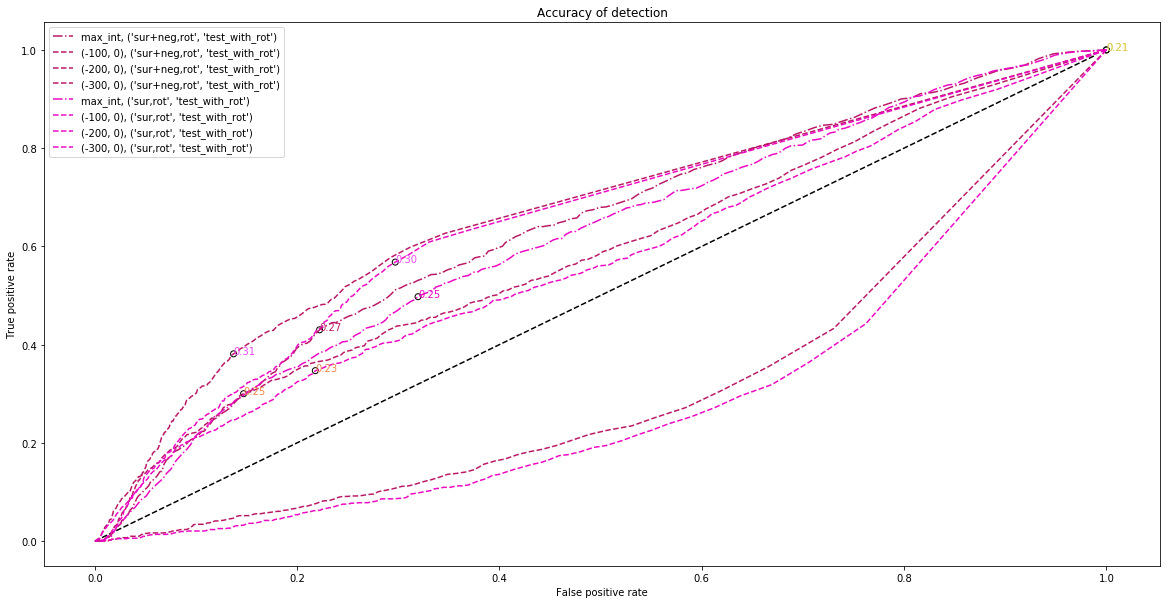

In [71]:
plt.figure(figsize=(20, 10));
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

for cond in conditions:
        
    fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh = \
    evaluate_scoremap(grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                      scores=best_sparse_scores[cond],
                     is_pos=is_pos, is_neg=is_neg)

    print cond, 'max_int', fopt, optimal_th

    if cond[1] == 'test_no_rot':
        linestyle = ':'
    elif cond[1] == 'test_with_rot':
        linestyle = '-.'
    else:
        raise

    if cond[0] == 72:
        clf_str = 'sur+neg,rot'
    elif cond[0] == 73:
        clf_str = 'sur,rot'
    elif cond[0] == 74:
        clf_str = 'sur,rot+int'
    elif cond[0] == 75:
        clf_str = 'sur+neg,rot+int'
    elif cond[0] == 76:
        clf_str = 'sur+neg,orig'        
    else:
        raise

    plt.plot([fp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                 [tp_allthresh[th] for th in np.arange(0, 1, 0.005)],
            label='%s, %s'%('max_int', str((clf_str,cond[1]))), 
             c=classifier_to_color[cond[0]], linestyle=linestyle);

    plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
                marker='o', facecolors='none', edgecolors='k')

    plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%.2f' % (fopt), 
             color=classifier_to_color[cond[0]])

    ###############
    
#     for intensity_range in [(-200, 0)]:
    for intensity_range in intensity_ranges:

        evaluation_results_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond] = \
        evaluate_scoremap(grid_indices=sparse_grids_allSchemes_allFns_allStructs[fn], 
                          scores=sparse_scores_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond],
                         is_pos=is_pos, is_neg=is_neg)

        fopt, optimal_th, precision_allthresh, recall_allthresh, f1score_allthresh, fp_allthresh, tp_allthresh = \
        evaluation_results_allSchemes_allFns_allStructs_allConditions[intensity_range][fn][structure][cond]

        print cond, intensity_range, fopt, optimal_th

        if cond[1] == 'test_no_rot':
            linestyle = '-'
        elif cond[1] == 'test_with_rot':
            linestyle = '--'
        else:
            raise

        if cond[0] == 72:
            clf_str = 'sur+neg,rot'
        elif cond[0] == 73:
            clf_str = 'sur,rot'
        elif cond[0] == 74:
            clf_str = 'sur,rot+int'
        elif cond[0] == 75:
            clf_str = 'sur+neg,rot+int'
        elif cond[0] == 76:
            clf_str = 'sur+neg,orig'
        else:
            raise

        plt.plot([fp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                     [tp_allthresh[th] for th in np.arange(0, 1, 0.005)],
                label='%s, %s'%(str(intensity_range), str((clf_str,cond[1]))), 
                 c=classifier_to_color[cond[0]], 
#                  c=intensity_to_color[intensity_range], 
                 linestyle=linestyle);

        plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
                    marker='o', facecolors='none', edgecolors='k')

        plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], '%.2f' % (fopt), 
#                  color=classifier_to_color[cond[0]]
                 color=intensity_to_color[intensity_range]
                )

evaluation_results_allSchemes_allFns_allStructs_allConditions.default_factory = None

plt.legend();
# plt.axis('equal');
plt.ylabel('True positive rate');
plt.xlabel('False positive rate');
plt.title('Accuracy of detection');
plt.show();

In [72]:
thresholds_allConditions_allSchemes = defaultdict(dict)
for cond in conditions:
    for intens in evaluation_results_allSchemes_allFns_allStructs_allConditions.keys():
        thresholds_allConditions_allSchemes[cond][intens] = evaluation_results_allSchemes_allFns_allStructs_allConditions[intens][fn][structure][cond][1]
thresholds_allConditions_allSchemes.default_factory = None

In [73]:
thresholded_scoremap_viz_allSchemes_allFns_allStructs_allConditions = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [76]:
downscale = 32
img_blue_intensity_normalized = {}

for fn in filenames:
    
    img_blue_local_region = img_blue[roi_ymin:(roi_ymin+roi_h), roi_xmin:(roi_xmin+roi_w)]
    
    for intens in intensity_ranges:
        low, high = intens
        if low == -100:
            mapping_fp = os.path.join(DATA_DIR, 'min_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region.astype(np.int)].astype(np.uint8)
        elif low == -200:
            mapping_fp = os.path.join(DATA_DIR, 'median_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region.astype(np.int)].astype(np.uint8)
        elif low == -300:
            mapping_fp = os.path.join(DATA_DIR, 'max_nissl_intensity_mapping.npy')
            download_from_s3(mapping_fp)
            intensity_mapping_ntb_to_nissl = np.load(mapping_fp)
            img_blue_intensity_normalized[intens] = intensity_mapping_ntb_to_nissl[img_blue_local_region.astype(np.int)].astype(np.uint8)
        else:
            img_blue_intensity_normalized[intens] = rescale_intensity_v2(img_blue_local_region, low, high)
            

    for structure in structures:
        for intens in intensity_ranges:
            for cond in conditions:

                def resample_scoremap(fn, s):
                    
                    downscaled_grid_y = np.arange(0, h, downscale)
                    downscaled_grid_x = np.arange(0, w, downscale)
                    downscaled_ny = len(downscaled_grid_y)
                    downscaled_nx = len(downscaled_grid_x)

                    sparse_scores = sparse_scores_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] 

                    f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
                    a = (sample_locations_roi - half_size)/spacing
                    f_grid[a[:,1], a[:,0]] = sparse_scores

                    yinterps = (downscaled_grid_y - half_size)/float(spacing)
                    xinterps = (downscaled_grid_x - half_size)/float(spacing)

                    points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
                    coord = np.c_[points_y.flat, points_x.flat]
                    f_interp = map_coordinates(f_grid, coord.T, order=1)
                    f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
                    scoremap = f_interp_2d.astype(np.float16)
                        
                    return scoremap

#                 t = time.time()
#                 scoremap = resample_scoremap(fn, structure)
                scoremap = resample_scoremap(fn, structure) > thresholds_allConditions_allSchemes[cond][intens]
    
                #         pool = Pool(NUM_CORES/2)
                #         # pool = Pool(1)
                #         scoremaps_allFns_allClasses = dict(zip(filenames, pool.map(resample, filenames)))
                #         pool.close()
                #         pool.join()
#                 sys.stderr.write('Resample scoremap: %.2f seconds\n' % (time.time() - t)) 

                #########################
    
                def save_scoremap(structure):
                    scoremap_viz = scoremap_overlay_on(bg=img_blue_intensity_normalized[intens], 
                                                       in_downscale=1, stack=stack, fn=fn, structure=structure,
                                                       scoremap=scoremap[roi_ymin/32:(roi_ymin+roi_h)/32,
                                                                           roi_xmin/32:(roi_xmin+roi_w)/32],
                                                      in_scoremap_downscale=32,
                                                      out_downscale=8, label_text=str(structure), 
                                                      cmap_name= 'jet')
                #         pool = Pool(NUM_CORES)
                #         structures = scoremaps_allClasses.keys()
                #         scoremap_viz_allSchemes_allFns_allStructs[(low,high)][fn] = dict(zip(structures, pool.map(save_scoremap, structures)))
                #         pool.close()
                #         pool.join()
                    return scoremap_viz

                t = time.time()

                for s in structures:
                    thresholded_scoremap_viz_allSchemes_allFns_allStructs_allConditions[intens][fn][s][cond] = save_scoremap(s)
                    
thresholded_scoremap_viz_allSchemes_allFns_allStructs_allConditions.default_factory = None

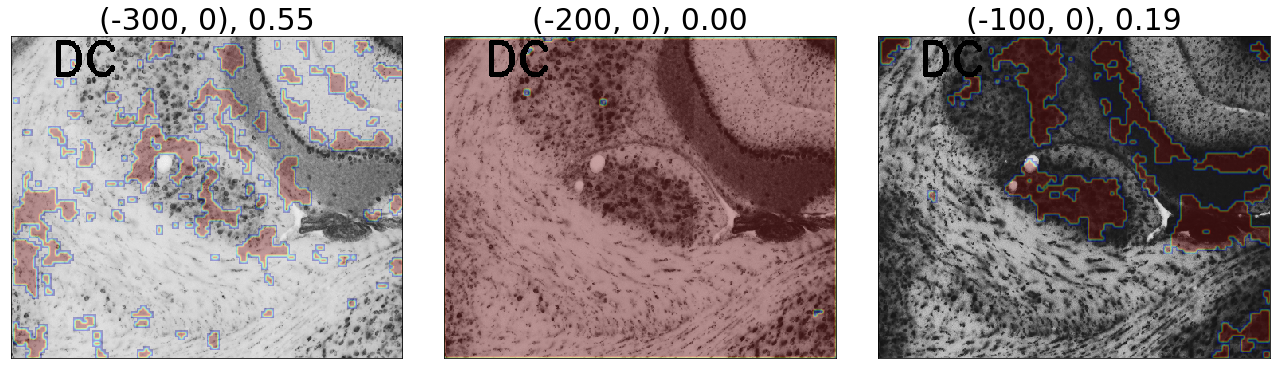

In [77]:
title_viz_tuples = [("%s, %.2f" % (str(scheme), thresholds_allConditions_allSchemes[(72,'test_with_rot')][scheme]), vizs[structures[0]][(72, 'test_with_rot')])
 for scheme, x in sorted(thresholded_scoremap_viz_allSchemes_allFns_allStructs_allConditions.items())
                    for fn, vizs in x.iteritems()                    
]

titles, vizs = zip(*title_viz_tuples)

display_images_in_grids(vizs=vizs, titles=titles, nc=3)